In [13]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [14]:
data = pd.read_sql("select * from sports_data.tourney_games_through_2023_final", conn)

In [15]:
data = data.replace(np.NaN, 0)

In [16]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [17]:
data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'opponent_season_win_pct', 'season_ppg',
       ...
       'opponent_vs_tourney_team_allowed_offensive_rebound_percent_std',
       'season_allowed_free_throw_rate',
       'opponent_season_allowed_free_throw_rate',
       'season_allowed_free_throw_rate_std',
       'opponent_season_allowed_free_throw_rate_std',
       'vs_tourney_team_allowed_free_throw_rate',
       'opponent_vs_tourney_team_allowed_free_throw_rate',
       'vs_tourney_team_allowed_free_throw_rate_std',
       'opponent_vs_tourney_team_allowed_free_throw_rate_std',
       'Win_Loss_Flag'],
      dtype='object', length=121)

In [18]:
predictor_cols = data.columns.to_list()

In [19]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [20]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [21]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [22]:
data['Win_Loss_Flag']

0       0
1       1
2       0
3       1
4       1
       ..
1237    0
1238    1
1239    0
1240    1
1241    0
Name: Win_Loss_Flag, Length: 1242, dtype: int64

In [23]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [24]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

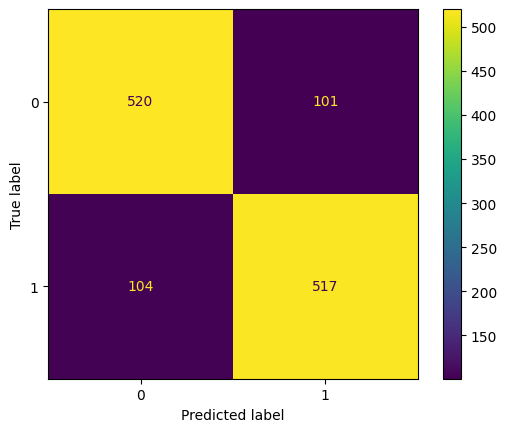

In [25]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [26]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [27]:
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])

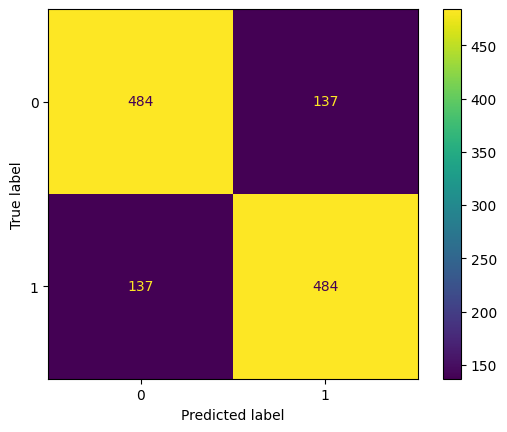

In [28]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [29]:
cms

array([[484, 137],
       [137, 484]], dtype=int64)

In [30]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [31]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [32]:
expected_games_right(cms)

accuracy: 0.7793880837359098


40.722315884376066

In [33]:
expected_score(cms)

87.71163570383781

accuracy: 0.785829307568438
expected games correct: 41.26933913864932
expected score: 89.76402058143337


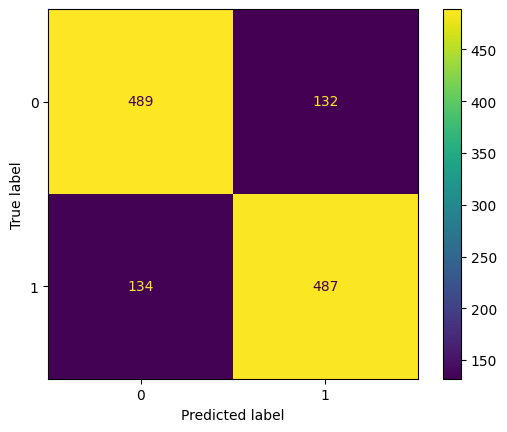

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=109)
pca.fit(prediction_data_normalized)
cms = proper_cross_validation(LogisticRegression(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

In [55]:
new_data = pd.read_sql("select * from sports_data.tourney_games_2024_potential", conn)
new_data = new_data.replace(np.NaN, 0)

In [153]:
wk = new_data[new_data['team'].str.contains('Conn')]
a = wk[wk['opponent'].str.contains('Hou')].head()[['season_ppg', 'season_ppg_allowed','opponent_season_ppg', 'opponent_season_ppg_allowed']]


In [156]:
(a['season_ppg'] + a['opponent_season_ppg'] + a['season_ppg_allowed'] + a['opponent_season_ppg_allowed']) / 2

32    136.705882
dtype: float64

In [56]:
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [57]:
new_prediction_data = new_data[predictor_cols]
new_prediction_data_normalized = (new_prediction_data-prediction_data.mean())/prediction_data.std()

In [72]:
new_data['prediction'] = clf.predict(new_prediction_data_normalized)
new_data['prediction_lose'] = [x[0] for x in clf.predict_proba(new_prediction_data_normalized)]
new_data['prediction_win'] = [x[1] for x in clf.predict_proba(new_prediction_data_normalized)]
preds = new_data[['season', 'team', 'opponent', 'prediction', 'prediction_lose', 'prediction_win']]

In [145]:
wk = preds[preds['team'].str.contains('Conn')]
wk[wk['opponent'].str.contains('Hou')]

,season,team,opponent,prediction,prediction_lose,prediction_win
32,2024,Connecticut,Houston,1,0.362846,0.637154
